## ***MNIST using 2 layer neural network***

# Implement a two-layer neural network to recognize hand-written digits


In [ ]:
# Uncomment the below line and run to install required packages if you have not done so

#!pip install torch torchvision matplotlib tqdm

In [ ]:
# Setup
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import trange

%matplotlib inline
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

## Get MNIST Data
The `torchvision` package provides a wrapper to download MNIST data. The cell below downloads the training and test datasets and creates dataloaders for each.

In [ ]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

## Use the following lines to check the basic statistics of this dataset
##Calculate training data mean and standard deviation to apply normalization to data
#train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

## Optional: Perform normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be approximately standard normal
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((train_mean, ), (train_std, ))
#])

train_data.transform = transform
test_data.transform = transform

batch_size = 64
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train Data: Mean=0.1306604762738429, Std=0.30810780717887876


## Inspect dataset

Images shape:  torch.Size([64, 1, 28, 28])
Labels shape:  torch.Size([64])
Mean=0.133231520652771, Std=0.3099796175956726


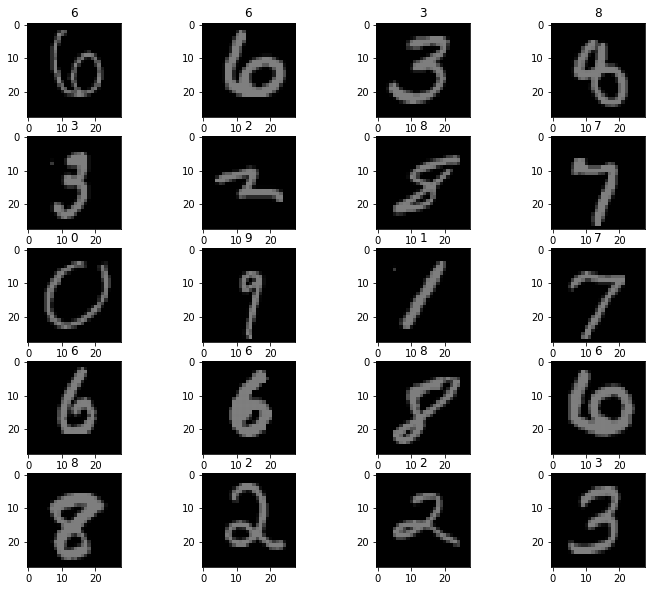

In [ ]:
# Randomly sample 20 images of the training dataset
# To visualize the i-th sample, use the following code
# > plt.subplot(4, 5, i+1)
# > plt.imshow(images[i].squeeze(), cmap='gray', interpolation='none')
# > plt.title(f'Label: {labels[i]}', fontsize=14)
# > plt.axis('off')

images, labels = iter(train_loader).next()

# Print information and statistics of the first batch of images
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)
print(f'Mean={images.mean()}, Std={images.std()}')

fig = plt.figure(figsize=(12, 10))

# ------------------
# Function to convert tensor to image
def image_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5))
  return image

for i in np.arange(20):
  ax = fig.add_subplot(5, 4, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(labels[i].item())
# ------------------

## Implement a two-layer neural network 

Write a class that constructs a two-layer neural network as specified in the handout. The class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

In [ ]:
input_size = 1 * 28 * 28  # input spatial dimension of images
hidden_size = 128         # width of hidden layer
output_size = 10          # number of output neurons

class MNISTClassifierMLP(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        # ------------------

        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.functional.log_softmax

        # ------------------
    
    def forward(self, x):
        # Input image is of shape [batch_size, 1, 28, 28]
        # Need to flatten to [batch_size, 784] before feeding to fc1
        x = self.flatten(x)

        # ------------------       
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        y_output = x
        
        return y_output
        # ------------------

model = MNISTClassifierMLP().to(DEVICE)

# sanity check
print(model)

MNISTClassifierMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Implement an optimizer to train the neural net model

Write a method called `train_one_epoch` that runs one step using the optimizer.

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # ------------------

        output = model(img)

        criterion = nn.NLLLoss()
        loss = criterion(output,label)

        # Backpropagation and optimization

        optimizer.zero_grad()
        loss.backward()  
        optimizer.step() 
               
        # ------------------
    
        # Record training loss every log_interval and keep counter of total training images seen
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

## Run the optimization procedure and test the trained model

Write a method called `test_one_epoch` that evalutes the trained model on the test dataset. Return the average test loss and the number of samples that the model predicts correctly.

In [ ]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------

            output = model(img)

            criterion = nn.NLLLoss()
            loss = criterion(output, label)

            pred = torch.argmax(output, 1) # Get index of largest log-probability and use that as prediction
            num_correct += torch.sum(pred == label)
            test_loss += loss.item()

            # ------------------
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

Train the model using the cell below. Hyperparameters are given.

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs=10
gamma = 0.95

# Recording data
log_interval = 100

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
tt_losses = []
tt_correct = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_loader, model, DEVICE)
    train_losss, train_num_correct = test_one_epoch(train_loader, model, DEVICE)

    # Record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    tt_losses.append(train_losss)
    tt_correct.append(train_num_correct)

print(f"Train accuracy: {tt_correct[-1]/len(train_loader.dataset)}")
print(f"Test accuracy: {test_correct[-1]/len(test_loader.dataset)}")
print(f"Test Loss: {test_losses}")
print(f"Train Loss: {tt_losses}")

Epochs: 100%|██████████| 10/10 [02:53<00:00, 17.34s/it]

Train accuracy: 0.9293333292007446
Test accuracy: 0.9314000010490417
Test Loss: [0.00924958386272192, 0.006371338571608066, 0.005492101474106312, 0.00507441203892231, 0.004746345206908881, 0.0045043962467461824, 0.004331964365020394, 0.004138823292404413, 0.003978280115593225, 0.0038462609554640948]
Train Loss: [0.009564827989041805, 0.006655937006324529, 0.0057439800245066485, 0.005287907769779364, 0.004955535595367352, 0.004689698090776801, 0.004474070281162858, 0.004275894067188104, 0.004096103636423746, 0.003929876461625099]


## Inspection:

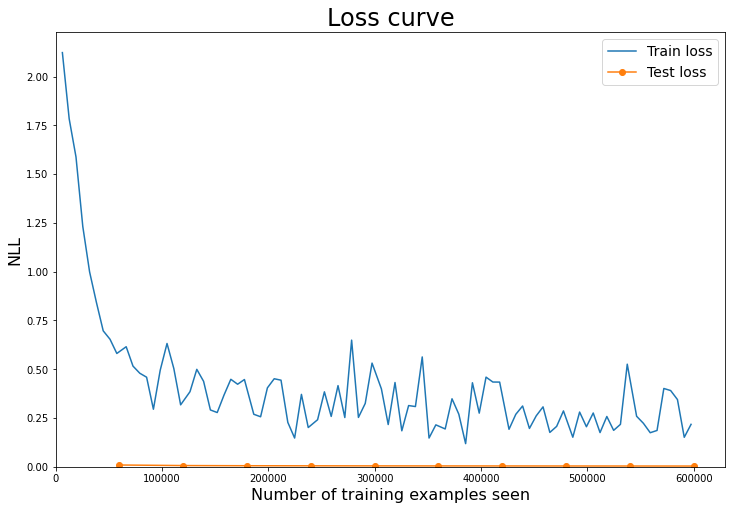

In [ ]:
# 1. Draw training loss curve
fig = plt.figure(figsize=(12,8))
plt.plot(train_counter, train_losses, label='Train loss')
plt.plot([i * len(train_loader.dataset) for i in range(1, max_epochs + 1)], 
         test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Number of training examples seen', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


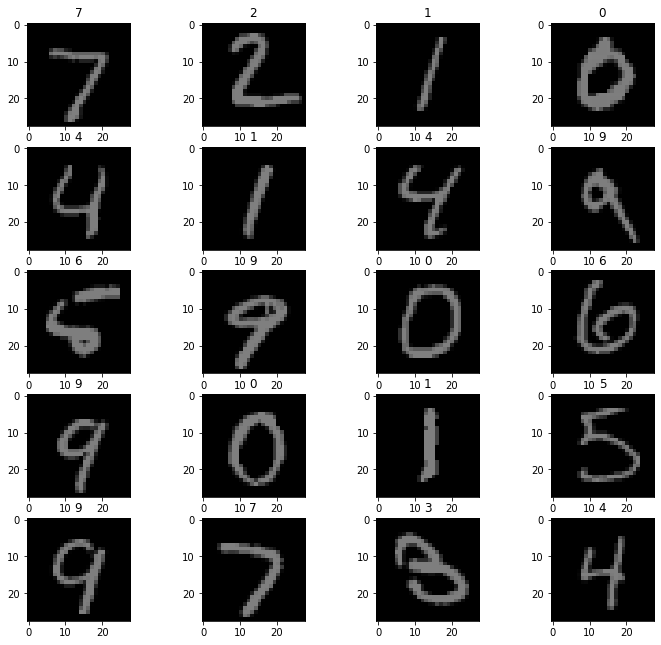

In [ ]:
# 2. Show the predictions of the first 20 images of the test dataset
images, labels = iter(test_loader).next()
images, labels = images.to(DEVICE), labels.to(DEVICE)

output = model(images)
pred = output.argmax(dim=1)

fig = plt.figure(figsize=(12, 11))
# ------------------

for i in np.arange(20):
  ax = fig.add_subplot(5, 4, i + 1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(pred[i].item())
# ------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


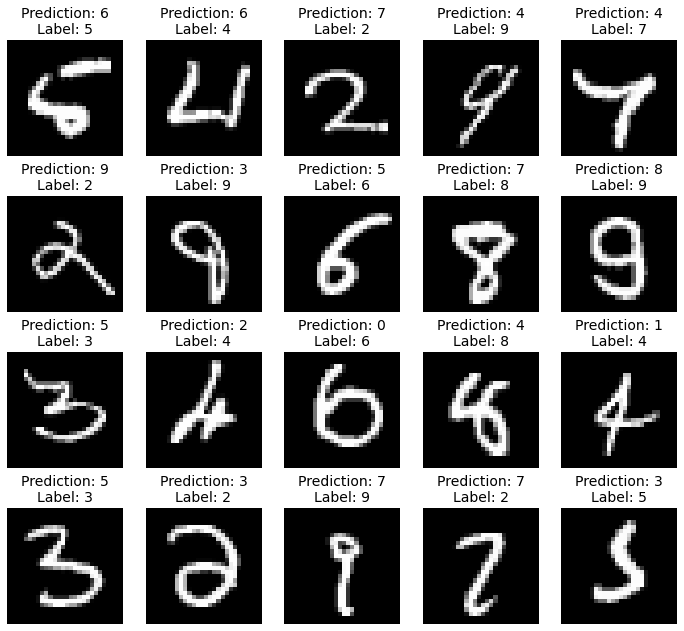

In [ ]:
# 3. Get 20 incorrect predictions in test dataset

# Collect the images, predictions, labels for the first 20 incorrect predictions
# Initialize empty tensors and then keep appending to the tensor.
# Make sure that the first dimension of the tensors is the total number of incorrect
# predictions seen so far
# Ex) incorrect_imgs should be of shape i x C x H x W, where i is the total number of 
# incorrect images so far.
incorrect_imgs = torch.Tensor().to(DEVICE)
incorrect_preds = torch.IntTensor().to(DEVICE)
incorrect_labels = torch.IntTensor().to(DEVICE)
misclassified=[]
misclassified_pred=[]
misclassified_target=[]
wrongPredictionIndexes = []

with torch.no_grad():
    # Test set iterator
    it = iter(test_loader)
    # Loop over the test set batches until incorrect_imgs.size(0) >= 20
    while incorrect_imgs.size(0) < 20:
        images, labels = it.next()
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # ------------------

        output = model(images)
        pred = output.argmax(dim=1, keepdim=True)

        # Compare prediction and true labels and append the incorrect predictions
        # using `torch.cat`.
        for idx, i in enumerate(output):
          if pred[idx] != labels[idx]:
            wrongPredictionIndexes.append(idx) 
            batch_misclassified = images[idx]
            batch_mis_pred = pred[idx]
            batch_mis_target = labels.view_as(pred)[idx]

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

        incorrect_imgs = torch.cat(misclassified)
        incorrect_preds = torch.cat(misclassified_pred)
        incorrect_labels = torch.cat(misclassified_target)      
        # ------------------
                
# Show the first 20 wrong predictions in test set
fig = plt.figure(figsize=(12, 11))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(incorrect_imgs[i].squeeze().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f'Prediction: {incorrect_preds[i].item()}\nLabel: {incorrect_labels[i].item()}', fontsize=14)
    plt.axis('off')